<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/ResNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short introduction to the Outlier package

In [52]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%tensorflow_version 2.x
import numpy as np
import os
import tensorflow_datasets as tfds

!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['info', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [53]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/Keras')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
######## hyper parameters
r_dropout = 0 #0.2
r_learn = 1e-4
r_noise = 0
crop = 0
size_img = 64
msg = '\n downsample 64, no crop'## additional message to pass on to plotting title

latest_file=None 
# latest_file=model_path+'/weights.50-0.020.hdf5'

In [0]:
S8_gen= lambda params: sqrt(params.T[0]/0.3)*params.T[1]

In [0]:
VERSION = tfds.core.Version('0.1.0')
dataset, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

In [0]:
## Implementing a simple resnet model
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[size_img,size_img])
    return x, y
  
def augmentation(x, y):
  # if crop:
  #   x = tf.image.random_crop(x, size=[size_img, size_img, 1]) 
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = tf.image.rot90(x, k=randint(4)) 
  # if r_noise: 
  #   x = x + r_noise*tf.random.normal(shape=(size_img,size_img,1))
  return x, y

In [0]:
DATASET_SIZE = 20000
BATCH_SIZE = 32*4

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

full_dataset = dataset.map(redefine)
if not crop:
  full_dataset = full_dataset.map(downsample)

train_dataset= full_dataset.take(train_size).repeat().map(augmentation).shuffle(buffer_size=2000).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).take(test_size).map(augmentation).batch(BATCH_SIZE)

### Let's define the neural network

In [59]:
inputs = tf.keras.Input(shape=(size_img, size_img, 1))
resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                    weights=None,
                                                    input_shape=[size_img,size_img,1],
                                                    pooling='avg',
              # classifier_activation=tf.keras.layers.LeakyReLU(alpha=0.3)
              )
net = resnet(inputs)
if r_dropout:
  net = tf.keras.layers.Dropout(r_dropout)(net)
outputs = tf.keras.layers.Dense(2)(net)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
resnet50v2 (Model)           (None, 2048)              23558528  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 23,562,626
Trainable params: 23,517,186
Non-trainable params: 45,440
_________________________________________________________________


In [0]:
# def newest(path):
#     files = os.listdir(path)
#     paths = [os.path.join(path, basename) for basename in files]
#     try:
#         return max(paths, key=os.path.getctime)
#     except:
#         return None

# latest_file=newest(model_path)

# print(latest_file)

### Training

In [61]:
checkpoint_file = os.path.join(model_path+'/weights.{epoch:02d}-{val_loss:.3f}.hdf5')
ckpt_callback   = keras.callbacks.ModelCheckpoint(filepath=checkpoint_file, monitor='val_loss', mode='min', period=10, save_best_only=True)
callbacks     = [ckpt_callback]

if latest_file is None:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mse')    
else:
  print(latest_file)
  model = keras.models.load_model(latest_file)

In [62]:
history = model.fit(train_dataset, epochs=50, batch_size=BATCH_SIZE,
                    verbose=1, 
                    steps_per_epoch=int(train_size/BATCH_SIZE)-1,
                    validation_data=test_dataset,validation_steps=6,
                    callbacks=callbacks
                    )

Epoch 1/50
124/124 [==============================] - 27s 214ms/step - loss: 0.1046 - val_loss: 0.0857
Epoch 2/50
124/124 [==============================] - 25s 202ms/step - loss: 0.0369 - val_loss: 0.0255
Epoch 3/50
124/124 [==============================] - 26s 210ms/step - loss: 0.0275 - val_loss: 0.0203
Epoch 4/50
124/124 [==============================] - 25s 202ms/step - loss: 0.0199 - val_loss: 0.0139
Epoch 5/50
124/124 [==============================] - 25s 201ms/step - loss: 0.0179 - val_loss: 0.0162
Epoch 6/50
124/124 [==============================] - 26s 207ms/step - loss: 0.0168 - val_loss: 0.0138
Epoch 7/50
124/124 [==============================] - 26s 207ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 8/50
124/124 [==============================] - 26s 207ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 9/50
124/124 [==============================] - 25s 205ms/step - loss: 0.0146 - val_loss: 0.0153
Epoch 10/50
124/124 [==============================] - 27s 214ms/step - l

In [63]:
truth = next(train_dataset.as_numpy_iterator()) 
print (truth[0].shape, truth[1].shape)
predictions = model.predict(x=truth[0])

truth_valid = next(test_dataset.as_numpy_iterator())
predictions_validation = model.predict(x=truth_valid[0])
params_valid = truth_valid[1]

params_pred = predictions
params_input = truth[1]
true_s8=S8_gen(params_input)
pred_s8=S8_gen(np.array(params_pred))

true_s8_valid=S8_gen(params_valid)
pred_s8_valid=S8_gen(np.array(predictions_validation))

losses_train=history.history['loss']
losses_val=history.history['val_loss']
epocharr=history.epoch

(128, 64, 64, 1) (128, 2)


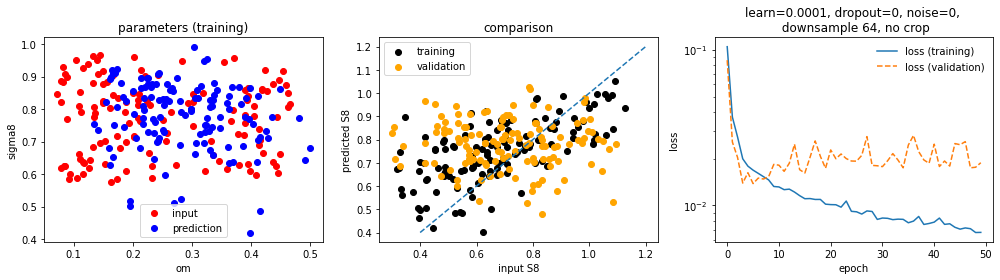

In [66]:
f, (ax1, ax2, ax3)=subplots(1,3, figsize=(14,4))

ax1.scatter(params_input.T[0], params_input.T[1],color='r', label='input')
ax1.scatter(params_pred.T[0], params_pred.T[1],color='b', label='prediction')
ax1.set_title('parameters (training)')
ax1.set_xlabel('om')
ax1.set_ylabel('sigma8')
ax1.legend(fontsize=10, frameon=1)
# ax1.set_xlim(0.05,0.5)
# ax1.set_ylim(0.5,1.)

ax2.scatter(true_s8, pred_s8, color='k',label='training')
ax2.scatter(true_s8_valid, pred_s8_valid, color='orange',label='validation')
ax2.plot([0.4, 1.2], [0.4, 1.2], '--')
ax2.legend(fontsize=10, frameon=1)
ax2.set_xlabel('input S8')
ax2.set_ylabel('predicted S8')
# ax2.set_ylim(0.2,1.2)
# ax2.set_xlim(0.2,1.2)
ax2.set_title('comparison')

ax3.plot(epocharr, losses_train,'-',label='loss (training)')
ax3.plot(epocharr, losses_val, '--',label='loss (validation)')
ax3.legend(fontsize=10, frameon=0)
ax3.set_xlabel('epoch')
ax3.set_ylabel('loss')
ax3.set_title('learn={0}, dropout={1}, noise={2}, {3}'.format(r_learn, r_dropout, r_noise, msg))
ax3.set_yscale('log')
plt.tight_layout()